# Board Management Monitoring

## Automated Analysis of Board Member and Management Activity Exposure

This workflow demonstrates the capabilities of Bigdata to monitor specific entities. In this example, we track the ‘People’ entity to identify where and when an individual is mentioned across selected documents.

## Why It Matters

Tracking specific individuals across news coverage is essential for governance analysis and investment decisions, but manually monitoring when and where these people are mentioned in thousands of articles is resource-intensive. This workflow leverages bigdata's entity tracking capabilities to systematically monitor individuals, providing comprehensive analysis of their media exposure and reputation signals to identify potential risks and opportunities.

## What It Does

This Board Management Monitoring workflow systematically tracks specific individuals across news coverage using multiple search strategies. Built for analysts, portfolio managers, and investment professional, it transforms scattered mentions into structured intelligence about management activity and board dynamics.

## How It Works

The workflow combines **multi-mode search strategies**, **entity-specific filtering**, and **temporal analysis** to deliver:

- **Comprehensive person tracking** across multiple name variations and contexts
- **Company-specific filtering** ensuring relevance to the monitored organization
- **Multi-mode search precision** from strict entity matching to broader coverage with post-filtering
- **Source filtering** enabling focused analysis across trusted news sources
- **Temporal analysis** showing how coverage patterns evolve over time

## A Real-World Use Case

This workflow demonstrates monitoring Emmanuel Faber from Danone S.A., tracking his exposure across management integrity themes and board governance topics, showing how different search modes capture varying levels of coverage.

## Setup and Imports
The following cell configures the necessary path for the analysis

In [4]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries
Below is the Python code required for setting up our environment and importing necessary libraries.



In [6]:
import os
import time
from datetime import datetime, date
from typing import List, Dict, Any, Optional, Tuple
import pandas as pd

from bigdata_client import Bigdata
from bigdata_client.models.search import DocumentType, SortBy
from bigdata_research_tools.search.search import run_search

import plotly.io as pio

from src.tool import (
    timer,
    run_monitoring_workflow,
    plot_combined_monitoring_activity,
    get_common_quarter_ticks,
    build_queries_for_monitoring,
    filter_documents_by_company,
    deduplicate_results,
    process_results_to_dataframe,
    plot_top_sources
)

## Plotly Display Configuration

In [7]:
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly
import plotly.io as pio
import plotly.graph_objects as go

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

In [8]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

## Load Credentials


In [9]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [10]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

# Parameters Definition

### Fixed Parameters
- **First Theme** (`news_search_mapping`): List of sentences about a theme you are interested in
- **Second Theme** (`board_themes`): List of sentences about a theme you are interested in  
- **Dates** (`date_periods`): List of tuples containing starting and ending date of a specific period of time. The dates used in this workflow are chosen to provide adequate temporal coverage surrounding the earnings dates
- **Trusted Sources** (`trusted_sources`): Dictionary containing the sources and their ID
- **Person of interest** (`persons_dict`): Dictionary containing the name of the person to search for, their ID and their possible different ways of naming them
- **Company of interest** (`company_name`, `company_id`): The name of the company to search for and a dictionary with its ID
- **Search Mode** (`search_mode`): Different ways of searching for that specific person
  - `strict`: Company entity and person must appear at chunk level
  - `relaxed`: Only person name variations are used
  - `relaxed_post`: Person search with company filtering at document level
- **Trusted Sources Flag** (`use_trusted_sources`): Flag to activate filtering with trusted sources

In [11]:
# Themes
news_search_mapping = [
    "Past Misconduct of Management",
    "Inconsistencies in Statements",
    "Whistleblower Allegations",
    "Negative Media Coverage on Integrity",
    "Accusations of Unethical Behavior",
    "Reputation of Management in Media",
    "Positive Analyst Ratings of Management",
    "Management's Reputation in Industry",
    "Introduction of Innovations",
    "Successful M&A Activities",
    "Company Turnaround Success",
    "Pressure from Activist Investors for Better Oversight",
    "External Audits or Reviews",
    "Changes in Board Composition",
    "Resignations Due to Oversight Concerns",
    "Conflicts of Interest Involving the Board",
    "Criticism of Corporate Governance Practices",
    "Reports Highlighting Oversight Issues",
    "Management Compensation Linked to Performance",
    "Shareholder-Friendly Capital Allocation",
    "Transparent Communication with Investors",
]

board_themes = [
    "Board member appointments and new director appointments",
    "Board member resignations and director departures",
    "Board meetings and governance proceedings",
    "Board member retirements and succession plans",
    "Death of board members and directors",
    "Board diversity and composition changes",
    "Board member compensation and salaries",
    "Board member firings and removals",
    "Board member health issues and medical leaves",
    "Board member absences and attendance issues"
]

# Time Ranges
date_periods = [
    ("2024-12-04", "2025-03-04"),
    ("2024-09-05", "2024-12-04"),
    ("2024-05-30", "2024-09-05"),
    ("2024-02-28", "2024-05-30"),
    ("2023-12-01", "2024-02-28"),
    ("2023-09-07", "2023-12-01"),
    ("2023-06-01", "2023-09-07"),
    ("2023-03-02", "2023-06-01"),
    ("2022-12-01", "2023-03-02"),
    ("2022-09-08", "2022-12-01"),
    ("2022-06-02", "2022-09-08"),
    ("2022-03-03", "2022-06-02"),
    ("2021-12-02", "2022-03-03"),
    ("2021-09-09", "2021-12-02"),
    ("2021-06-03", "2021-09-09"),
    ("2021-03-04", "2021-06-03"),
    ("2020-12-03", "2021-03-04"),
    ("2020-09-10", "2020-12-03"),
    ("2020-06-06", "2020-09-10"),
    ("2020-03-07", "2020-06-06"),
    ("2020-01-19", "2020-03-07")
]

# Trusted sources
use_trusted_sources = False # Set True to activate the filter

trusted_sources = {
    'The Economist': '5B7D72','Washington Post': 'DC6F95', 
    'Bloomberg News': '208421', 'The Washington Post Blog': '471CDE',
    'BNN Bloomberg': '7490C8', 'CNN': '2435A4',
    'BBC': 'A61D00', 'FOX Business': '2D0020',
    'Reuters': '751371', 'Financial Times': 'DA9FC6',
    'Wall Street Journal': 'AA6E89', 'CNBC': 'AA1167',
    'MarketWatch': '1E5E35', 'Washington Post Via Web': 'B6ACEE',
    'Forbes': '22AC8B', "Investor's Business Daily": '15B968','Al Jazeera (English)': 'CD85BA',

}

# Person Details
persons_dict = {
    'Emmanuel Faber': {
        'id': '6D9368',
        'variations': [
            'Emmanuel Faber',    # First Name + Last Name
            'E. Faber',         # Initial + Last Name
            'Faber, Emmanuel',   # Last Name + comma + First Name
            'Emmanuel F.'         # First Name + Initial
        ]
    }
}

#Company Details
company_name = 'Danone S.A.'
company_data = {'id': '3E149C'}


## Multi-Mode Monitoring Execution

In [ ]:
search_modes = ["strict", "relaxed", "relaxed_post"]

selected_sources = trusted_sources if use_trusted_sources else None
results_files = {}


for search_mode in search_modes:
    print(f"\nRunning {search_mode.upper()} mode monitoring...")

    with timer(f"{search_mode} mode execution"):
        # Build queries for current search mode
        queries, date_ranges, query_details = build_queries_for_monitoring(
            date_periods=date_periods,
            persons=persons_dict,
            company=company_data,
            news_search_mapping=news_search_mapping,
            board_themes=board_themes,
            search_mode=search_mode,
            sources=selected_sources,
            use_source_filter=use_trusted_sources
        )

        # Execute search
        search_results = run_search(
            queries=queries,
            date_ranges=date_ranges,
            sortby=SortBy.RELEVANCE,
            scope=DocumentType.NEWS,
            limit=100,
            only_results=True,
            rerank_threshold=None
        )

        # Filter and process results
        filtered_results = filter_documents_by_company(
            search_results=search_results,
            query_details_template=query_details,
            company_name=company_name,
            search_mode=search_mode
        )

        # Remove duplicates
        deduplicated_results = deduplicate_results(filtered_results)

        # Convert to structured DataFrame
        df_results = process_results_to_dataframe(deduplicated_results)

        # Save results
        source_type = "trusted" if use_trusted_sources else "all"
        output_file = os.path.join(
            output_dir,
            f"board_monitoring_{search_mode}_{source_type}_sources.csv"
        )
        df_results.to_csv(output_file, index=False, encoding="utf-8-sig")
        results_files[search_mode] = output_file

        print(f"{search_mode.upper()} mode: {df_results.shape[0]} documents saved to {output_file}")

## Results Analysis and Visualization

In [12]:
# Load results from all three search modes
df_strict = pd.read_csv("output/board_monitoring_strict_all_sources.csv")
df_relaxed = pd.read_csv("output/board_monitoring_relaxed_all_sources.csv")
df_relaxed_post = pd.read_csv("output/board_monitoring_relaxed_all_sources.csv")

print("Search Mode Comparison:")
print(f"Strict Mode: {len(df_strict)} documents")
print(f"Relaxed Mode: {len(df_relaxed)} documents")
print(f"Relaxed Post Mode: {len(df_relaxed_post)} documents")

Search Mode Comparison:
Strict Mode: 97 documents
Relaxed Mode: 172 documents
Relaxed Post Mode: 172 documents


## Quarterly Activity Visualization

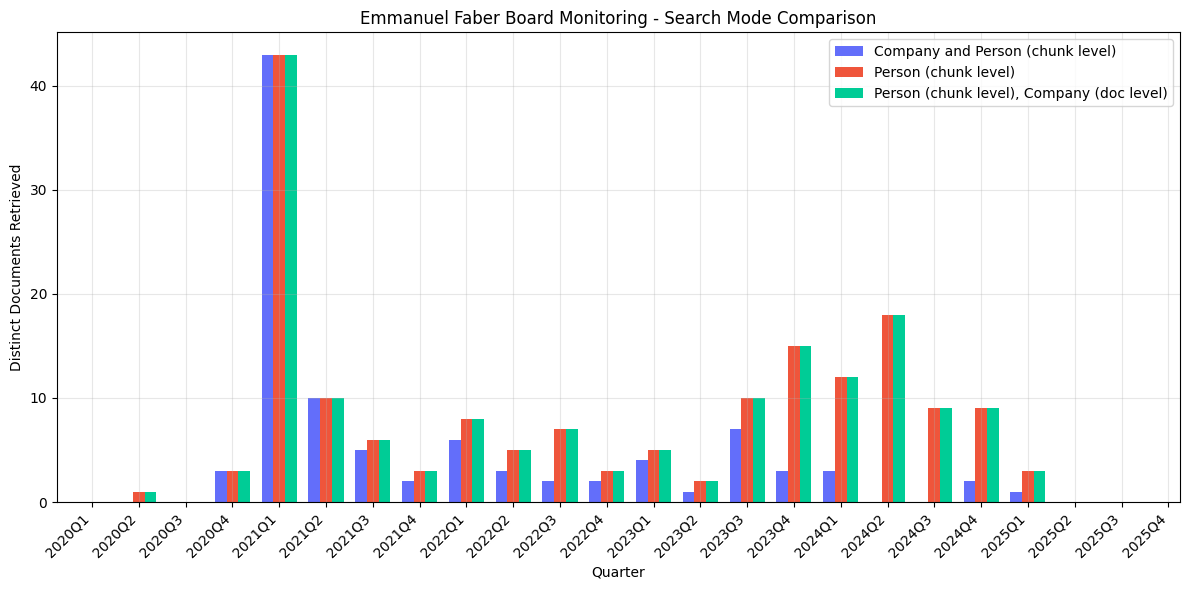

In [17]:
# Generate quarterly comparison visualization
common_tick_dates, common_tick_text = get_common_quarter_ticks("2020Q1", "2025Q4")
x_axis_range = [common_tick_dates[0], common_tick_dates[-1]]

# Create comprehensive comparison chart
fig_combined = plot_combined_monitoring_activity(
    df_strict,
    df_relaxed,
    df_relaxed_post,
    title="Emmanuel Faber Board Monitoring - Search Mode Comparison",
    x_range=x_axis_range,
    tick_vals=common_tick_dates,
    tick_text=common_tick_text,
    interactive=True # set to False to have the static plot
)

# Display the visualization
fig_combined.show()

## Key Insights and Analysis

Coverage Analysis:
• Strict Mode captures the most precise mentions with company co-occurrence
• Relaxed Mode provides comprehensive coverage but may include false positives
• Relaxed Post Mode offers balanced precision-recall by post-filtering for company mentions

Temporal Patterns:
• Peak activity period in Strict Mode: 2021Q1
• Peak activity period in Relaxed Mode: 2021Q1


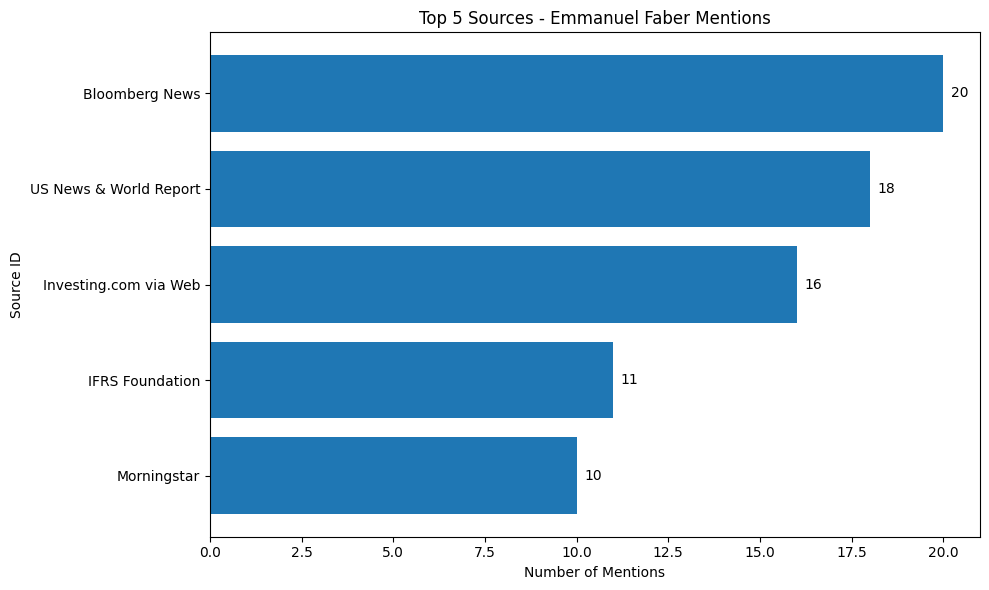

In [16]:
print("Coverage Analysis:")
print("• Strict Mode captures the most precise mentions with company co-occurrence")
print("• Relaxed Mode provides comprehensive coverage but may include false positives")
print("• Relaxed Post Mode offers balanced precision-recall by post-filtering for company mentions")

print("\nTemporal Patterns:")
strict_dates = pd.to_datetime(df_strict['Date']).dt.tz_localize(None).dt.to_period('Q').value_counts().sort_index()
relaxed_dates = pd.to_datetime(df_relaxed['Date']).dt.tz_localize(None).dt.to_period('Q').value_counts().sort_index()


if len(strict_dates) > 0 and len(relaxed_dates) > 0:
    print(f"• Peak activity period in Strict Mode: {strict_dates.idxmax()}")
    print(f"• Peak activity period in Relaxed Mode: {relaxed_dates.idxmax()}")


plot_top_sources(df_relaxed, person_name="Emmanuel Faber", top_n=5, interactive=True) # set to False to have the static plot

## Export and Final Analysis

In [15]:
# Create comprehensive summary
summary_data = {
    'Search Mode': ['Strict', 'Relaxed', 'Relaxed Post'],
    'Documents Retrieved': [len(df_strict), len(df_relaxed), len(df_relaxed_post)],
    'Unique Sources': [
        df_strict['SourceID'].nunique() if len(df_strict) > 0 else 0,
        df_relaxed['SourceID'].nunique() if len(df_relaxed) > 0 else 0,
        df_relaxed_post['SourceID'].nunique() if len(df_relaxed_post) > 0 else 0
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(output_dir, "monitoring_summary.csv"), index=False)

print("Final Summary:")
print(summary_df.to_string(index=False))

print(f"\nBoard Management Monitoring completed successfully!")
print(f"Results saved in: {output_dir}")

Final Summary:
 Search Mode  Documents Retrieved  Unique Sources
      Strict                   97              29
     Relaxed                  172              54
Relaxed Post                  172              54

Board Management Monitoring completed successfully!
Results saved in: output
